In [6]:
import sys
sys.path.append("../")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch.utils.data import random_split

import torch.autograd.profiler as profiler
from torch.cuda.amp import autocast, GradScaler

import apex.fp16_utils as fp16

import os
import numpy as np
from sklearn.datasets import make_classification
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser
import matplotlib.pyplot as plt
%matplotlib inline

from utils.moduleCodeProfiler import rankByCriteria

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


In [3]:
!nvidia-smi

Sun Nov 22 23:52:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 000099D1:00:00.0 Off |                    0 |
| N/A   42C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
cuda0 = torch.device('cuda:0') 

In [5]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
args = parser.parse_args('')

args.data_dir = '~/datadrive'
args.dataset_dir = 'toy_mlp_1'
args.seed = 123
args.batch_size = 1000
# https://stackoverflow.com/questions/15753701/how-can-i-pass-a-list-as-a-command-line-argument-with-argparse
args.hidden_layer_dims = [10, 10, 10, 10]
args.lr = 0.01
args.epochs = 20

# Toy Data Generation

In [5]:
# construct and save toydataset

m_train = 9000
m_total = m_train

X, y = make_classification(n_samples=m_total, n_features=10, n_informative=10, n_redundant=0, n_repeated=0, n_classes=5, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=args.seed)
# y = np.expand_dims(y, -1)

np.random.seed(args.seed)
permutation = np.random.permutation(m_total)
print('First 10 training indices', permutation[:10])
print('X shape', X.shape)
print('y shape', y.shape)

train_indices = permutation[0:m_train]

dataset_dir = 'toy_mlp_1'
os.makedirs(os.path.join(args.data_dir, dataset_dir, 'train'), mode = 0o777, exist_ok = True) 

np.save(os.path.join(args.data_dir, dataset_dir, 'train', 'features.npy'), X[train_indices])
np.save(os.path.join(args.data_dir, dataset_dir, 'train', 'labels.npy'), y[train_indices])

First 10 training indices [1603 8472 2213  498 1038 8399 3324 7535 1519 1959]
X shape (9000, 10)
y shape (9000,)


In [6]:
class ToyDataset(Dataset):
    """Toy dataset construction."""

    def __init__(self, data_dir):
        """
        Args:
            data_dir (string): Path to the directory with data files.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # shape (m, nx)
        self.X = np.load(os.path.join(data_dir, 'features.npy'))
        # shape (m, ny=1)
        self.y = np.load(os.path.join(data_dir, 'labels.npy'))
        

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        else:
            X = torch.from_numpy(self.X[idx, :]).type(torch.FloatTensor)
            y = torch.tensor(self.y[idx], dtype=torch.long)
#             y = torch.from_numpy(self.y[idx, :]).type(torch.FloatTensor)
            sample = {'X': X, 'y': y}

        return sample

In [ ]:
# TODO

class ToyDataModule(pl.LightningDataModule):
    # https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw

    def __init__(self, batch_size, V, seed, context_len, tot_size):
        super().__init__()
        self.batch_size=batch_size
        self.V = V
        self.seed = seed
        self.context_len = context_len
        self.tot_size = tot_size

    def setup(self, stage=None):
        if stage == 'fit' or stage in None:
            self.toy_train = ToyDataset(
                V=self.V, seed=self.seed, 
                context_len=self.context_len, tot_size=self.tot_size)
            self.toy_val = self.toy_train            
            # self.toy_val = ToyDataset(
            #     V=self.V, seed=42, 
            #     context_len=self.context_len, tot_size=self.batch_size*2) 
        if stage == 'test' or stage is None:
            self.toy_test = self.toy_train
            # self.toy_test = ToyDataset(
            #     V=self.V, seed=41, 
            #     context_len=self.context_len, tot_size=self.batch_size*2)
            
    def train_dataloader(self):
        train_loader = DataLoader(self.toy_train, batch_size=self.batch_size, shuffle=False)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.toy_val, batch_size=self.batch_size, shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = DataLoader(self.toy_test, batch_size=self.batch_size, shuffle=False)
        return test_loader

# Model

In [8]:
class MLPLazy(nn.Module):

    def __init__(self, nx, hidden_layer_dims, ny):
        super(MLPLazy, self).__init__()
        self.hidden_layer_dims = hidden_layer_dims
        
        linear_layers = []
        last_dim = nx
        for next_dim in hidden_layer_dims:
            linear_layer = nn.Linear(last_dim, next_dim)
            linear_layers.append(linear_layer)
            last_dim = next_dim
        # should push to ModuleList so that params stay on cuda
        self.linear_layers = nn.ModuleList(linear_layers)
        self.scorer = nn.Linear(last_dim, ny)

    def forward(self, X):
        '''
        X has shape (m, nx)
        '''
        last_X = X
        for i, linear_layer in enumerate(self.linear_layers):
            # shape (m, self.hidden_layer_dims[i])
            last_X = linear_layer(last_X)
            # shape (m, self.hidden_layer_dims[i])
            last_X = torch.relu(last_X)
        # shape (m, ny)
        z = self.scorer(last_X)
#         # shape (m, ny)
#         a = torch.softmax(z, dim=1)
        return z

# Workflow

In [8]:
def check_weights_precision(model):
    '''check weight precisions for each layer of MLP'''
    for i, layer in enumerate(model.linear_layers):
        print(f'layer {i}, weight dtype {layer.weight.dtype}')
        print(f'layer {i}, bias dtype {layer.bias.dtype}')
    print(f'scorer weight dtype {model.scorer.weight.dtype}')
    print(f'scorer bias dtype {model.scorer.bias.dtype}')

In [9]:
def get_max_memory_alloc():
    '''read and reset max memory allocation'''
    devices_max_memory_alloc = {}
    for i in range(torch.cuda.device_count()):
        device = torch.device(f'cuda:{i}')
        devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
        torch.cuda.reset_max_memory_allocated(device)
    return devices_max_memory_alloc

In [ ]:
class MLPMixedPrecision(pl.LightningModule):
    
    def __init__(self, hparams):
        super().__init__()
        
        self.hparams = hparams
        # 1. Create model
        self.model = MLPLazy(hparams['nx'], hparams['hidden_layer_dims'], hparams['ny'])
        self.model_pgs, self.master_pgs = None, None
        self.loss_criterion = nn.CrossEntropyLoss(reduction='mean')
        self.loss_scale = 50000
        self.overflow = False

    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
        
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    def forward(self, X, Y):
        assert X.dtype == torch.float16
        assert Y.dtype != torch.float16 or Y.dtype != torch.long
        
        # 6. model forward with float16 data
        logits = self.model(X)
        # 7. compute loss in float16
        loss = self.loss_criterion(logits, Y)
        # 8. scale up loss here
        loss *= self.loss_scale
        # 8.1 check if loss overflow
        self.overflow = torch.isinf(loss)
        return loss, logits
        
    def training_step(self, batch, batch_nb):
        self.overflow = False
        X, Y = batch
        loss, logits = self(X, Y)
        step_metrics = {'train_loss': loss, 'loss_scale': self.loss_scale}
        
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
            
        self.log_metrics(step_metrics)
        return loss
        
    def validation_step(self, batch, batch_nb):
        X, Y = batch
        loss, logits = self(X, Y)
        step_metrics = {'val_loss': loss}
        self.log_metrics(step_metrics)
        return step_metrics
        
    def test_step(self, batch, batch_nb):
        X, Y = batch
        loss, logits = self(X, Y)
        step_metrics = {'test_loss': loss}
        self.log_metrics(step_metrics)        
        return step_metrics
        
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        epoch_metrics = {
            'avg_val_loss': avg_loss
        }
        self.log_metrics(epoch_metrics)        
        return epoch_metrics
        
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        epoch_metrics = {
            'avg_test_loss': avg_loss
        }
        self.log_metrics(epoch_metrics)        
        return epoch_metrics

    def check_grad(self):
        print('optimizer grad:\n', self.optimizers().param_groups[0]['params'][0].grad)
        print('master pg grad:\n', self.master_pgs[0][0].grad)
        print('model pg grad:\n', self.model_pgs[0][0].grad)

    def check_weights(self):
        print('optimizer weights:\n', self.optimizers().param_groups[0]['params'][0])
        print('master pg weights:\n', self.master_pgs[0][0])
        print('model pg weights:\n', self.model_pgs[0][0])
    
    def get_master(self, opt):
        '''create a float32 master copy of float16 model weights in optimizer'''
        model_pgs = [[param for param in pg['params'] if param.requires_grad] for pg in opt.param_groups]
        master_pgs = [[param.clone().float().detach() for param in pg] for pg in model_pgs]
        for pg in master_pgs:
            for param in pg: param.requires_grad_(True)
        return model_pgs, master_pgs

    def push_master_to_optimizer(self, opt, master_pgs):
        '''
            link master copy pgs to optimizer, 
            keeping other hparams such as lr, momentum dampening, weight_decay... etc
        '''
        for opt_pg, master_pg in zip(opt.param_groups, master_pgs):
            opt_pg['params'] = master_pg

    def to_master_grads(self, model_pgs, master_pgs):
        '''copy float16 gradients from model to float32 gradients in master copy of weights'''
        for (model_params, master_params) in zip(model_pgs,master_pgs):
            fp16.model_grads_to_master_grads(model_params, master_params, flat_master=False)
       
    def scale_down_master_grad(self, master_pgs, loss_scale):
        '''
        scale down all gradients for all master param groups
        '''
        for master_params in master_pgs:
            for param in master_params:
                if param.grad is not None:
                    param.grad.div_(loss_scale)
    
    def configure_optimizers(self):
        # 2. initialize optimizer
        opt = torch.optim.SGD(self.model.parameters(), lr=self.hparams['lr'])
        # 3. Cast model to float16
        fp16.convert_network(self.model, torch.float16)
        # 4. Create a copy of this float16 model's weight in float32 as the master copy
        self.model_pgs, self.master_pgs = self.get_master(opt)
        # 5. replace optimizer float16 weights with float32 master copy
        self.push_master_to_optimizer(opt, self.master_pgs)
        return opt
    
    def backward(self, loss: Tensor, optimizer: Optimizer, optimizer_idx: int, *args, **kwargs) -> None:
        if self.trainer.train_loop.automatic_optimization or self._running_manual_backward:
            if not self.overflow:
                # 9. backprop to compute gradients
                loss.backward(*args, **kwargs)
                # 10. check if gradient overflow
                self.overflow = any(
                    [torch.any(torch.isinf(p.grad)).item() for pg in self.model_pgs for p in pg]
                )
            if self.overflow:
                # half the loss scale
                self.loss_scale /= 2.
                self.model.zero_grad()
            else:
                # up the loss scale
                self.loss_Scale *= 1.05
                # 11. copy float16 gradients from model to float32 gradients in master copy of weights
                self.to_master_grads(self.model_pgs, self.master_pgs)
                # 12. scale down master copy gradients
                self.scale_down_master_grad(self.master_pgs, self.loss_scale)
                
    def optimizer_step(
        self,
        *args,
        epoch: int = None,
        batch_idx: int = None,
        optimizer: Optimizer = None,
        optimizer_idx: int = None,
        optimizer_closure: Optional[Callable] = None,
        on_tpu: bool = None,
        using_native_amp: bool = None,
        using_lbfgs: bool = None,
        **kwargs,
    ) -> None:
        if not self.overflow:
            # 13.optimizer step on master weights
            optimizer.step(closure=optimizer_closure, *args, **kwargs)
            # 14.zero out gradients in model
            self.model.zero_grad()
            # 15.copy float32 master weights to float16 model weights
            self.to_model_params(self.model_pgs, self.master_pgs)
            
        
#     def optimizer_zero_grad(
#         self, epoch: int, batch_idx: int, optimizer: Optimizer, optimizer_idx: int
#     ):
#         optimizer.zero_grad()

# Train

In [12]:
!nvidia-smi

Sun Nov 22 22:43:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 000099D1:00:00.0 Off |                    0 |
| N/A   54C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
history, model = main_train(args, debug=True)


model weights at init
layer 0, weight dtype torch.float32
layer 0, bias dtype torch.float32
layer 1, weight dtype torch.float32
layer 1, bias dtype torch.float32
layer 2, weight dtype torch.float32
layer 2, bias dtype torch.float32
layer 3, weight dtype torch.float32
layer 3, bias dtype torch.float32
scorer weight dtype torch.float32
scorer bias dtype torch.float32


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


In [13]:
with profiler.profile(profile_memory=True, record_shapes=True, use_cuda=False, with_stack=True) as prof:
    with profiler.record_function("forward"):
        history, model = main_train(args, debug=True)


model weights at init
layer 0, weight dtype torch.float32
layer 0, bias dtype torch.float32
layer 1, weight dtype torch.float32
layer 1, bias dtype torch.float32
layer 2, weight dtype torch.float32
layer 2, bias dtype torch.float32
layer 3, weight dtype torch.float32
layer 3, bias dtype torch.float32
scorer weight dtype torch.float32
scorer bias dtype torch.float32


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


# Training Results

In [13]:
# Ran without profiler
history

{'train_losses': [1.6131540536880493,
  1.6128689050674438,
  1.6125844717025757,
  1.6123093366622925,
  1.6120353937149048,
  1.6117639541625977,
  1.6114981174468994,
  1.6112393140792847,
  1.610988736152649,
  1.610745906829834,
  1.6105149984359741,
  1.6102882623672485,
  1.610068678855896,
  1.6098577976226807,
  1.6096543073654175,
  1.60945463180542,
  1.6092621088027954,
  1.6090692281723022,
  1.6088793277740479,
  1.6086912155151367],
 'max_memory_allocation': [{device(type='cuda', index=0): 0.005632},
  {device(type='cuda', index=0): 0.325632},
  {device(type='cuda', index=0): 0.330752},
  {device(type='cuda', index=0): 0.330752},
  {device(type='cuda', index=0): 0.330752},
  {device(type='cuda', index=0): 0.330752},
  {device(type='cuda', index=0): 0.330752},
  {device(type='cuda', index=0): 0.330752},
  {device(type='cuda', index=0): 0.330752},
  {device(type='cuda', index=0): 0.330752},
  {device(type='cuda', index=0): 0.331264},
  {device(type='cuda', index=0): 0.3312

# Loss Scale

In [14]:
history['loss_scales']

[65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,
 65536.0,


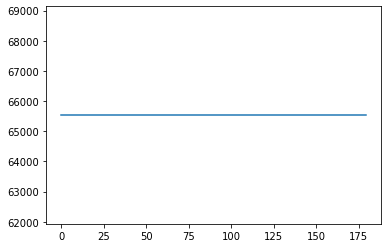

In [15]:
plt.plot(np.arange(len(history['loss_scales'])), np.array(history['loss_scales']))

# Profiler Results

In [14]:
rankByCriteria(prof, model, criteria='cuda_memory_usage', per_thread=False, per_inp_shapes=False, include_external=False)

Ranked by cuda_memory_usage

29.57 Mb
##############################################
model, aten::addmm, forward, (24) last_X = linear_layer(last_X)
3.23 Mb
##############################################
model.scorer, aten::addmm, forward, (93) return F.linear(input, self.weight, self.bias)
model, aten::addmm, forward, (24) last_X = linear_layer(last_X)
3.23 Mb
##############################################
model, aten::empty, forward, (26) last_X = torch.relu(last_X)
2.81 Mb
##############################################
model, aten::resize_, forward, (24) last_X = linear_layer(last_X)
1.41 Mb
##############################################
model.scorer, aten::resize_, forward, (93) return F.linear(input, self.weight, self.bias)
model, aten::resize_, forward, (24) last_X = linear_layer(last_X)
1.41 Mb
##############################################
model, aten::relu, forward, (26) last_X = torch.relu(last_X)
1.41 Mb
##############################################
model, aten::threshold, 

# Nvidia Results

In [16]:
# Ran without profiler
!nvidia-smi

Sun Nov 22 22:43:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 000099D1:00:00.0 Off |                    0 |
| N/A   56C    P0    58W / 149W |    338MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
# Ran without profiler
print(torch.cuda.memory_summary(cuda0))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   10240 B  |  340480 B  |   88046 KB |   88036 KB |
|       from large pool |       0 B  |       0 B  |       0 KB |       0 KB |
|       from small pool |   10240 B  |  340480 B  |   88046 KB |   88036 KB |
|---------------------------------------------------------------------------|
| Active memory         |   10240 B  |  340480 B  |   88046 KB |   88036 KB |
|       from large pool |       0 B  |       0 B  |       0 KB |